## Import libraries

In [1]:
import json
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

## Open the csv from the batch download and convert to JSON
### Also open a previous stats file if you've already collected that

In [2]:
#change the name here to your csv file
batchdf = pd.read_csv('IAState-250-recent-items.csv',encoding='utf8')
result = batchdf.to_json(orient="records")
full_articles = json.loads(result)

In [3]:
#Open an existing stats file that matches you batch metadata file (Otherwise, continue to next step)
dfstats = pd.read_csv('article-stats.csv',encoding='utf8')

## Collect stats (unless you've already done this)

In [42]:
#Create a list of all the article ids
article_ids = [item['id'] for item in full_articles]

In [15]:

#Create csv file
metadata=open('article-stats.csv', 'w', newline='')
#Write header row to csv
csv.writer(metadata).writerow(['id','views','downloads'])            

            
for l in article_ids:
    s=requests.get('https://stats.figshare.com/total/views/article/'+ str(l))
    r=json.loads(s.text)
    t=requests.get('https://stats.figshare.com/total/downloads/article/'+ str(l))
    q=json.loads(t.text)
    
    #write the values to the csv file. Dates in json files are seconds from jan 1 1970 so datetime.datetime.fromtimestamp converts
    csv.writer(metadata).writerow([
        l,
        r.get('totals'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'. However, metadata assessment counts non nulls
        q.get('totals')]) 
    
    
metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf8 error.
dfstats = pd.read_csv('article-stats.csv',encoding='utf8')

print('The resulting dataframe has',len(dfstats),'rows')

The resulting dataframe has 171 rows


## Summarize and Examine

From here on out, you need the batch metadata csv/dataframe, the json version of that csv, and the stats csv/dataframe.
Here are the dataframes:

- batchdf (all metadata but the funding and categories are formatted still)
- full_articles (JSON version of batchdf to be used to extract funding and category information)
- dfstats (Views and downloads for each record, this will be merged with full_articles)


## Merge metadata with stats

In [4]:
#Merge the dataframes
df_final = batchdf.merge(dfstats, how='inner', on='id')
len(df_final)

171

## Extract values from JSON formatted fields

In [5]:
#Extract funding lists to a dataframe. The "JSON" is currently stored as a big list.

funders = []
for i in full_articles:
    info = {"itemid": i['id'], "funding_list": list(eval(i['funding_list']))} #eval converts the string to a list
    funders.append(info)

fundersdf = pd.json_normalize(
    funders, 
    record_path =['funding_list'], 
    meta=['itemid']
)


In [6]:
#Extract categories lists to a dataframe
categories = []
for i in full_articles:
    #license_list.append((i['license']['name'],i['doi']))
    info = {"itemid": i['id'], "categories": list(eval(i['categories']))}
    categories.append(info)

categorydf = pd.json_normalize(
    categories, 
    record_path =['categories'], 
    meta=['itemid']
)

Now there are three dataframes: df_final with all metadata, categorydf with a list of categories, and fundersdf with a list of funder names.

In [7]:
#Look at licenses
df_final['license'].value_counts()

https://creativecommons.org/licenses/by/4.0/          156
https://creativecommons.org/publicdomain/zero/1.0/     13
https://opensource.org/licenses/MIT                     2
Name: license, dtype: int64

In [8]:
#Look at links to publications
linkbacks = df_final['resource_doi'].unique()
len(linkbacks)

25

In [17]:
#Create a dataframe of unique funders by item id and add views and downloads
funderuniques = fundersdf[['funder_name','itemid']].copy()
funderuniques = funderuniques.drop_duplicates()

#Merge the dataframes
funder_stats = funderuniques.merge(dfstats, how='inner', left_on=['itemid'], right_on=['id'])

#Count records
funder_view_count = funder_stats.groupby('funder_name')['views'].sum().reset_index().sort_values(by='views', ascending=False)


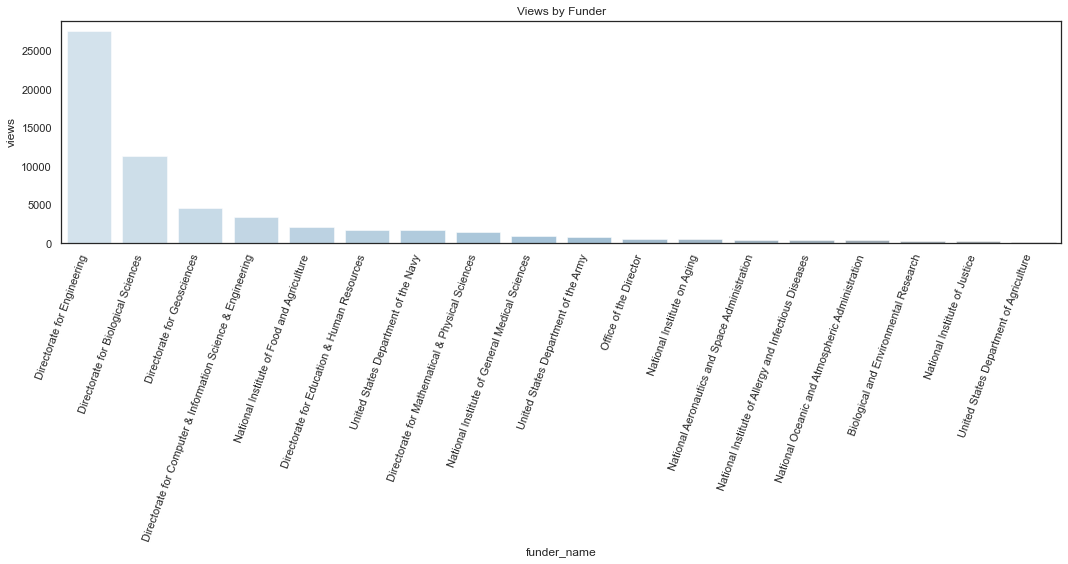

In [27]:
#Look at views by linked funder
plt.figure(figsize=(15,8))
sns.set_theme(style="white")
sns.barplot(x='funder_name', y="views",
            alpha=.5, palette="Blues_d",
            data=funder_view_count, ci=None).set(title='Views by Funder')
plt.xticks(rotation=70, ha="right")
plt.tight_layout()

In [22]:
cat_count = categorydf.title.value_counts().reset_index().rename(
           columns={'index': 'category', 'title': 'count'})

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Climatology'),
  Text(1, 0, 'Other environmental sciences not elsewhere classified'),
  Text(2, 0, 'Other earth sciences not elsewhere classified'),
  Text(3, 0, 'Statistics not elsewhere classified'),
  Text(4, 0, 'Forensic evaluation, inference and statistics'),
  Text(5, 0, 'Conservation and biodiversity'),
  Text(6, 0, 'Materials engineering not elsewhere classified'),
  Text(7, 0, 'Agronomy'),
  Text(8, 0, 'Applied statistics'),
  Text(9, 0, 'Genomics')])

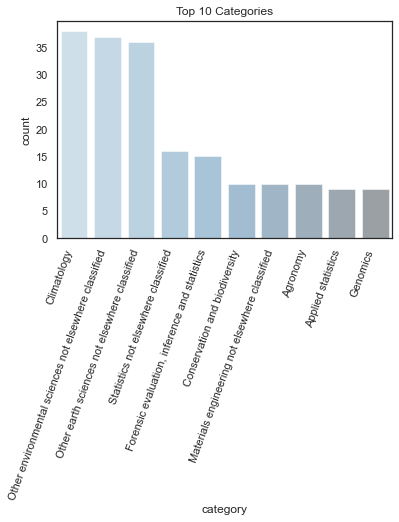

In [24]:
top_cats = cat_count.head(10)
sns.set_theme(style="white")
sns.barplot(x='category', y="count",
            alpha=.5, palette="Blues_d",
            data=top_cats, ci=None).set(title='Top 10 Categories')
plt.xticks(rotation=70, ha="right")
